In [482]:
import math, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa.display
import os

import torch
import torchaudio
from torchaudio import transforms
from torch.utils.data import DataLoader, Dataset, random_split

import torch.nn.functional as F
import torch.nn as nn
from tqdm.auto import tqdm
import torch.optim as optim

------
## 1. Preprocessing of data: 

### 1. Audio Utilities:

In [483]:
class AudioUtil ():
    
    @staticmethod
    def open (audio_file):
        sig, sr = torchaudio.load(audio_file)
        return (sig, sr) 
    
    @staticmethod
    def spectro_gram (aud, n_mels = 16, n_fft = 1024, hop_len = 1024):
        sig, sr = aud
        top_db = 80
        spec = transforms.MelSpectrogram(sr,n_fft = n_fft, n_mels = n_mels, hop_length = hop_len)(sig)
        spec = transforms.AmplitudeToDB(top_db = top_db)(spec)
        return (spec)
    
    @staticmethod
    def spectro_augment(spec, max_mask_pct=0.1, n_freq_masks=1, n_time_masks=1):
        _, n_mels, n_steps = spec.shape
        mask_value = spec.mean()
        aug_spec = spec

        freq_mask_param = max_mask_pct * n_mels
        for _ in range(n_freq_masks):
            aug_spec = transforms.FrequencyMasking(freq_mask_param)(aug_spec, mask_value)

        time_mask_param = max_mask_pct * n_steps
        for _ in range(n_time_masks):
            aug_spec = transforms.TimeMasking(time_mask_param)(aug_spec, mask_value)

        return aug_spec

### 2. Sound data set:

In [484]:
class SoundDS (Dataset): 
    
    def __init__ (self, df, data_path):
        self.df = df
        self.data_path = str (data_path)
        self.sr = 48000
        
    def __len__ (self):        
        return (len(self.df))
        
    def __getitem__(self, idx):
        audio_file = self.data_path + self.df.loc[idx, "realtive_path"]
        class_id = torch.tensor(self.df.loc[idx, 'Y'], dtype = float)
        aud = AudioUtil.open(audio_file)
        sgram = AudioUtil.spectro_gram(aud,  n_fft=1024,n_mels=64, hop_len=1024)
        #aug_sgram = AudioUtil.spectro_augment(sgram, max_mask_pct=0.1, n_freq_masks=2, n_time_masks=2)
        sgram_m, sgram_s = sgram.mean(), sgram.std()
        #class_m, class_s = class_id.mean(), class_id.std()
        sgram = (sgram -  sgram_m)/sgram_s
        #class_id = (class_id - class_m)/class_s
        return sgram, class_id

------
## 1. Artificial Neural network (ANN): 

## 1. Model building: 

In [485]:
class regressionNN (nn.Module):
    
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
          nn.Linear(64*141, 512),
          nn.ReLU(),
          nn.Linear(512, 265),
         nn.ReLU(),
          nn.Linear(265, 128),
          nn.ReLU(),  
          nn.Linear(128, 64),
          nn.ReLU(),    
          nn.Linear(64, 32),
          nn.ReLU(),  
           nn.Linear(32, 1)
#          nn.ReLU(),    
#          nn.Linear(16, 1)
        )
    
    def forward(self, x):
        x = x.view(-1,64*141) # reshape the input tensor
        return self.layers(x)

## 2. Preparing training data: 

In [486]:
df = pd.read_csv("/Users/mohammeda.salha/Desktop/MISCADA/The final project/The code/Dataframes/LL_exp3_0.csv")
Labels = torch.tensor(df["Y"], dtype=float)
Labels_m, Labels_s = Labels.mean(), Labels.std()
df["Y"] = (Labels-Labels_m)/Labels_s
data_path=r'/Users/mohammeda.salha/Desktop/MISCADA/The final project/The code'
myds = SoundDS(df, data_path)

In [487]:
num_items = len(myds)
num_train = round(num_items * 0.8)
num_val = num_items - num_train
train_ds, val_ds = random_split(myds, [num_train, num_val])
# Create training and validation data loaders
train_dl =torch.utils.data.DataLoader(train_ds, batch_size=64, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=64, shuffle=True)

In [488]:
# In case you need to load training data. 
'''
training = []
for k, (i , j) in enumerate (train_dl):
    training.append(i)
    if k == num_train:
        break
'''

'\ntraining = []\nfor k, (i , j) in enumerate (train_dl):\n    training.append(i)\n    if k == num_train:\n        break\n'

In [489]:
num_train

2040

## 3. Loading Valid data

In [490]:
df1 = pd.read_csv("/Users/mohammeda.salha/Desktop/MISCADA/The final project/The code/Dataframes/LL_exp3_1.csv")
Labels1 = torch.tensor(df1["Y"], dtype=float)
Labels1_m, Labels1_s = Labels1.mean(), Labels1.std()
df1["Y"] = (Labels1-Labels1_m)/Labels1_s
data_path=r'/Users/mohammeda.salha/Desktop/MISCADA/The final project/The code'
myds1 = SoundDS(df1, data_path)

In [491]:
test_dl =torch.utils.data.DataLoader(myds1, batch_size=len(myds1), shuffle=False)

In [492]:
# In case you need to load training data. 
'''
valid = []
for k, (i , j) in enumerate (test_dl):
    valid.append(i)
    if k == len(test_dl):
        break    
'''

'\nvalid = []\nfor k, (i , j) in enumerate (test_dl):\n    valid.append(i)\n    if k == len(test_dl):\n        break    \n'

### 4. Model employment: 

In [493]:
exp2model = regressionNN()
criterion = nn.MSELoss()
weight_decay = 1e-4
optimizer = optim.Adam(exp2model.parameters(),lr = 0.00001, weight_decay = weight_decay)

In [494]:
#list(exp2model.layers[4].parameters())

In [495]:
epoch = 0
num_epochs = 20
losses = []
val_losses = []
pbar = tqdm(total=num_epochs)

while epoch < num_epochs: 
    
    epoch += 1
    steps = list(enumerate(train_dl))
    current_loss = 0.0
    for i, (x_batch, y_batch) in steps: 
        x_batch = x_batch.float()
        y_batch = y_batch.float()
        y_batch_pred = exp2model(x_batch)
        loss = criterion(y_batch_pred.view(-1,len(y_batch)),y_batch.view(-1,len(y_batch)))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss1, current = loss.item(), (i+1)*len(x_batch)
        losses.append(loss1)
    for x_batch1, y_batch1 in test_dl:
        x_batch1 = x_batch1.float()
        y_batch1 = y_batch1.float()
        y_batch1_pred = exp2model(x_batch1)
        loss1 = criterion(y_batch1_pred.view(-1,len(y_batch1)),y_batch1.view(-1,len(y_batch1)))
        val_losses.append(loss1)
    pbar.update(1)


  0%|          | 0/20 [00:00<?, ?it/s]

## Loading the model (Location is temproraly):

In [362]:
path = "/Users/mohammeda.salha/Desktop/MISCADA/The final project/The code/The saved models/Exp3/lower epochs"
loaded_parameters = torch.load(os.path.join(path,f"exp3_{1e-5}.pth"))

In [363]:
exp2model = regressionNN()
exp2model.load_state_dict(loaded_parameters["model_state"])

<All keys matched successfully>

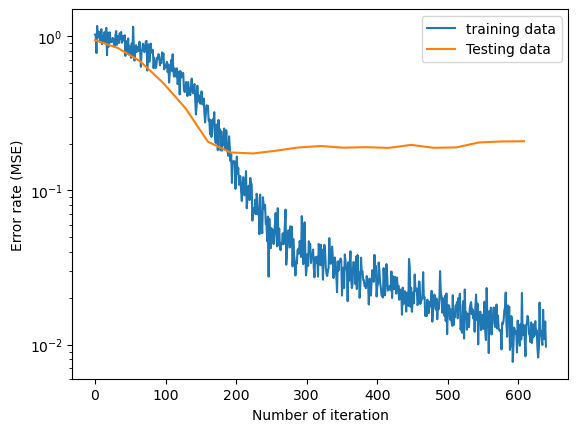

In [432]:
with torch.no_grad():
    plt.plot(losses, label = "training data")
    plt.plot(np.arange(len(val_losses))*32, val_losses, label = "Testing data")
    plt.yscale("log")
    plt.ylabel("Error rate (MSE)")
    plt.xlabel("Number of iteration")
    plt.legend()

## 5. Checking the resulted data (training data set): 

### 1. Plot the histogram

In [433]:
a1 = np.array([])
a1targets = np.array([])
for i, (x_batch, y_batch) in enumerate(list(train_dl)): 
    x1 = exp2model(x_batch)
    #*Labels_s + Labels_m
    with torch.no_grad():
        a1 = np.append(a1,x1.numpy()*Labels_s.numpy() + Labels_m.numpy())
        a1targets = np.append(a1targets,y_batch.numpy()*Labels_s.numpy() + Labels_m.numpy())
                

In [434]:
possible = set(a1targets)

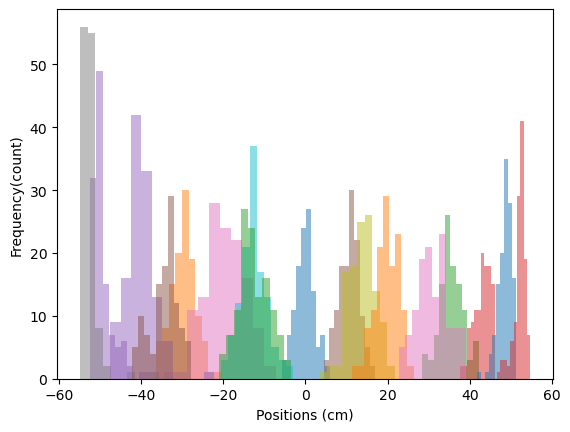

In [435]:
for p in possible:
    plt.hist(a1[a1targets==p], alpha=0.5, label=f'{p}')
    plt.xlabel("Positions (cm)")
    plt.ylabel("Frequency(count)")
#plt.legend()

### 2. Plot the spectogram:

In [398]:
#librosa.display.specshow(np.array(inputs[60]), sr = 48000, x_axis = "linear")

### 3. Find mean and std of each value:  

In [436]:
possible1 = list(possible)
possible1.sort()
print(possible1)

[-55.0, -50.0, -40.0, -35.0, -30.0, -20.0, -15.0, -10.0, 0.0, 10.0, 15.0, 20.0, 30.0, 35.0, 40.0, 50.0, 55.0]


In [437]:
values_class = []
for p in possible1:
    values_class.append(a1[a1targets==p])

In [438]:
values = [-55,-50,-40,-35,-30,-20,-15,-10,0,10,15,20,30,35,40,50,55]

for i in range (17): 
    with torch.no_grad():
        current_mean = (values_class[i]).mean()
        current_std = (values_class[i]).std()
        print(f"The mean of {[values[i]]} is {current_mean} and {current_std}")


The mean of [-55] is -49.365168232028765 and 2.5014298681377505
The mean of [-50] is -52.53002873862662 and 2.109866565594308
The mean of [-40] is -40.157686185836795 and 3.3775465083382166
The mean of [-35] is -34.446387224030076 and 3.3917136807682766
The mean of [-30] is -29.654866711846715 and 2.8780074384984418
The mean of [-20] is -19.542049869658456 and 4.876453620876153
The mean of [-15] is -12.667124553521473 and 3.1478537246877494
The mean of [-10] is -12.60788659351628 and 3.676945382471061
The mean of [0] is -0.13975760906982093 and 2.3131449771699084
The mean of [10] is 10.597599100878858 and 2.4624401714623634
The mean of [15] is 13.732198098610187 and 3.2394569057431215
The mean of [20] is 19.85594545950101 and 2.8572176298828045
The mean of [30] is 30.99966847799658 and 3.7731719268105453
The mean of [35] is 35.452344258626304 and 2.8430669608578056
The mean of [40] is 43.04783044781601 and 1.9846428266469824
The mean of [50] is 48.65388653972956 and 1.6292207618838914


In [439]:
values = [-55,-50,-40,-35,-30,-20,-15,-10,0,10,15,20,30,35,40,50,55]
means = []
stds = []
for i in range (17): 
    with torch.no_grad():
        means.append((values_class[i]).mean())
        stds.append((values_class[i]).std())
       

In [440]:
lengths = []
for i in range (17): 
    lengths.append(len(values_class[i]))
np.average(lengths)

120.0

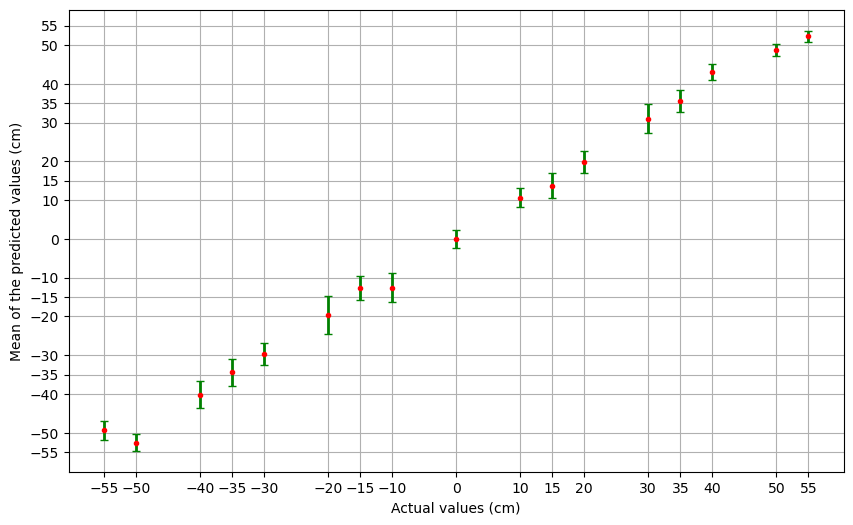

In [441]:
plt.figure(figsize = (10,6))
plt.errorbar(values,means, yerr = stds,fmt=".", color='red',
             ecolor='green', elinewidth=2, capsize=3)
plt.xticks(np.array(values))
plt.yticks(np.array(values))
plt.xlabel("Actual values (cm)")
plt.ylabel ("Mean of the predicted values (cm)")
plt.grid()


#### Find a mean and std errors in all values: 

In [442]:
values = np.array([-55,-50,-40,-35,-30,-20,-15,-10,0,10,15,20,30,35,40,50,55])
errors = np.array([])
for i in range (len(values)): 
    with torch.no_grad():
        error = values[i] - values_class[i]
        errors = np.append(errors,error)
errors.std()


3.6200367163882405

In [443]:
#Maximum difference in a mean
index_max_mean = (np.array(means)-np.array(values)).argmax()
print(f"Maximum difference in a mean is {values[index_max_mean]-means[index_max_mean]} for a value of {values[index_max_mean]}")
#Maximum difference in an std
print(f"Maximum difference in an std is {stds[np.array(stds).argmax()]} for a value of {values[np.array(stds).argmax()]}")

Maximum difference in a mean is -5.634831767971235 for a value of -55
Maximum difference in an std is 4.876453620876153 for a value of -20


### 4. Saving the model: 

In [407]:
path = "/Users/mohammeda.salha/Desktop/MISCADA/The final project/The code/The saved models/Exp3/lower epochs"
paratosave = {"model_state": exp2model.state_dict(), "optimizer_state":optimizer.state_dict(),"train_losses":losses,\
             "valid_losses":val_losses, "num_epoch": num_epochs }
torch.save(paratosave, os.path.join(path,f"exp3_{weight_decay}.pth"))

In [408]:
training_loss = []
valaid_loss = []

### 5. Loading the model: 

In [409]:
path = "/Users/mohammeda.salha/Desktop/MISCADA/The final project/The code/The saved models/Exp3/lower epochs"
loaded_parameters = torch.load(os.path.join(path,"exp3_1e-05.pth"))

In [410]:
exp2model = regressionNN()
exp2model.load_state_dict(loaded_parameters["model_state"])

<All keys matched successfully>

In [411]:
training_loss.append(loaded_parameters["losses"])

KeyError: 'losses'

----------
## 6. Checking the resulted data (Valid data set): 

In [444]:
df1 = pd.read_csv("/Users/mohammeda.salha/Desktop/MISCADA/The final project/The code/Dataframes/exp3_1data.csv")
Labels1 = torch.tensor(df1["Y"], dtype=float)
Labels1_m, Labels1_s = Labels1.mean(), Labels1.std()
df1["Y"] = (Labels1-Labels1_m)/Labels1_s
data_path=r'/Users/mohammeda.salha/Desktop/MISCADA/The final project/The code'
myds1 = SoundDS(df1, data_path)

In [445]:
len(myds1)

160

In [446]:
test_dl =torch.utils.data.DataLoader(myds1, batch_size=len(myds1), shuffle=False)

In [447]:
for inputs, labels in test_dl: 
    a = torch.round(exp2model(inputs)*Labels_s + Labels_m )
    b = torch.round(labels*Labels1_s + Labels1_m)

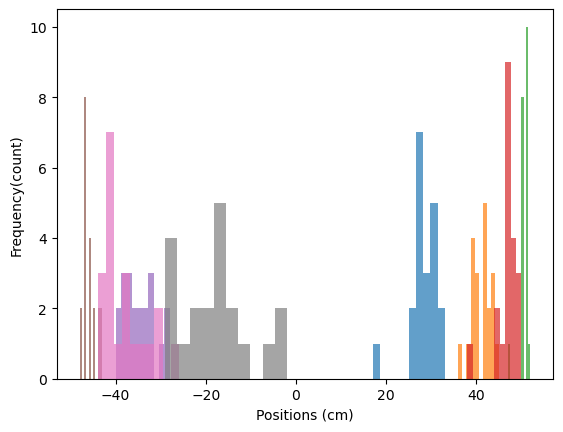

In [448]:
with torch.no_grad():
    for i in range(8):
        plt.hist(a.view(-1,len(a))[0][20*i:20*(i+1)].numpy(),alpha=0.7, label=f'{i}')
        plt.xlabel("Positions (cm)")
        plt.ylabel("Frequency(count)")


In [449]:
points = [25, 45, 60, 70, -25,-45,-60,-70]
for i in range (8): 
    current = a.view(-1,len(a))[0][i*20:(i+1)*20]
    print (f"The mean of {[points[i]]} is {current.mean()} and std is {current.std()}")

The mean of [25] is 28.350000381469727 and std is 3.4224491119384766
The mean of [45] is 41.150001525878906 and std is 2.390221357345581
The mean of [60] is 50.45000076293945 and std is 0.9986833333969116
The mean of [70] is 46.849998474121094 and std is 2.412140369415283
The mean of [-25] is -34.849998474121094 and std is 3.407036066055298
The mean of [-45] is -46.0 and std is 1.521771788597107
The mean of [-60] is -38.0 and std is 5.099019527435303
The mean of [-70] is -17.649999618530273 and std is 7.902531147003174


In [450]:
means = []
stds = []
values = [25, 45, 60, 70, -25,-45,-60,-70]
for i in range (8): 
    current = a.view(-1,len(a))[0][i*20:(i+1)*20]
    means.append(current.mean())
    stds.append(current.std())

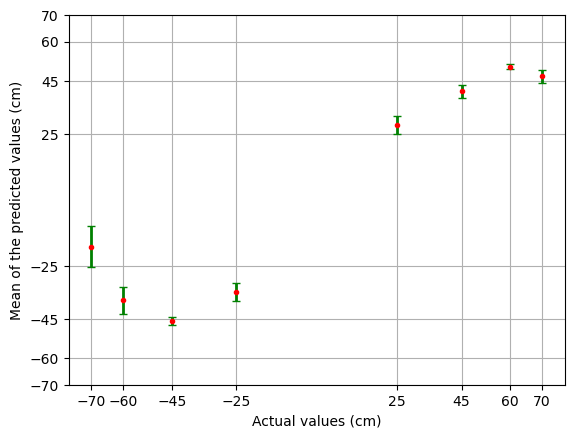

In [451]:
with torch.no_grad():
    plt.errorbar(values,means, yerr = stds,fmt=".", color='red',
                 ecolor='green', elinewidth=2, capsize=3)
    plt.xticks(np.array(values))
    plt.yticks(np.array(values))
    plt.xlabel("Actual values (cm)")
    plt.ylabel ("Mean of the predicted values (cm)")
    plt.grid()


In [452]:
values = [25, 45, 60, 70, -25,-45,-60,-70]
errors = np.array([])
for i in range (len(values)): 
    with torch.no_grad():
        error = values[i] - values_class[i]
        errors = np.append(errors,error)
errors.std()


65.71125620066908

In [453]:
#Maximum difference in a mean
with torch.no_grad():
    index_max_mean = (np.array(means)-np.array(values)).argmax()
    print(f"Maximum difference in a mean is {values[index_max_mean]-means[index_max_mean]} for a value of {values[index_max_mean]}")
    #Maximum difference in an std
    print(f"Maximum difference in an std is {stds[np.array(stds).argmax()]} for a value of {values[np.array(stds).argmax()]}")

Maximum difference in a mean is -52.349998474121094 for a value of -70
Maximum difference in an std is 7.902531147003174 for a value of -70


### Reporting the results: 

In [387]:
current = ((a.view(-1,len(a))-b.view(-1,len(b)))**2).sum()/len(a)
valaid_loss.append(current)

NameError: name 'valaid_loss' is not defined

In [685]:
print(current)

tensor(2984.3750, dtype=torch.float64, grad_fn=<DivBackward0>)


### Splitting the predictions of the validation data to two sets: 

In [388]:
good_predictions = np.array([])
bad_predictions = np.array([])
good_set = np.array([-45, 25, 45, 60])
bad_set = np.array([-25, -60, -70, 70 ])

with torch.no_grad():
    for i in good_set: 
        good_predictions= np.append(good_predictions,a.view(-1,len(a))[b.view(-1,len(b))==i])
    for i in bad_set: 
        bad_predictions= np.append(bad_predictions,a.view(-1,len(a))[b.view(-1,len(b))==i])

    

In [389]:
error_good = np.array([])
for i in range (len(good_set)): 
    error_good = np.append(error_good,(good_set[i] - good_predictions[i*20: (i+1)*20])[:])
error_good.std()

5.687211531145997

In [390]:
error_bad = np.array([])
for i in range (len(bad_set)): 
    error_bad = np.append(error_bad,(bad_predictions[i*20: (i+1)*20]-bad_set[i])[:])
error_bad.std()

29.63637967093822

In [391]:
bad_predictions

array([-35., -38., -30., -40., -37., -42., -33., -37., -40., -35., -38.,
       -34., -39., -33., -37., -34., -30., -39., -38., -34., -32., -41.,
       -42., -43., -41., -42., -24., -38., -38., -44., -43., -36., -43.,
       -36., -42., -34., -35., -41., -33., -33.,  -9., -28., -31.,  -5.,
       -21., -32., -23., -24., -31., -23., -26., -29., -20., -16., -16.,
       -20., -18., -18., -10., -19.,  46.,  45.,  45.,  45.,  45.,  43.,
        44.,  43.,  42.,  44.,  36.,  40.,  42.,  43.,  45.,  45.,  44.,
        46.,  46.,  46.])

## Plot the losses against the regularization: 

In [392]:
train_losse = []
valid_losse = []
x = [1, 1e-1, 1e-2, 1e-3,1e-4,1e-5,1e-6]

In [393]:
path = "/Users/mohammeda.salha/Desktop/MISCADA/The final project/The code/The saved models/Exp3/lower epochs"
for i in x: 
    loaded_parameters = torch.load(os.path.join(path,f"exp3_{i}.pth"))
    with torch.no_grad():
        train_losse.append(loaded_parameters["train_losses"][-1])
        valid_losse.append(loaded_parameters["valid_losses"][-1])


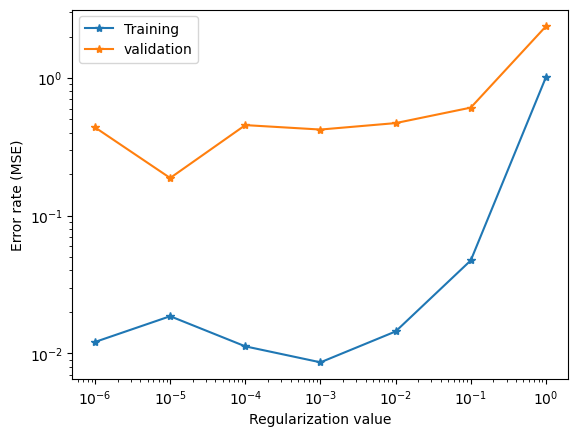

In [394]:
x = [1, 1e-1, 1e-2, 1e-3,1e-4,1e-5,1e-6]
with torch.no_grad():
    plt.plot(x,train_losse, label = "Training", marker='*')
    plt.plot(x,valid_losse, label = "validation",marker='*' )
    plt.ylabel("Error rate (MSE)")
    plt.xlabel("Regularization value")
    plt.xscale("log")
    plt.yscale("log")
    plt.legend()
